[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/structural-break/quickstarters/random-submission/random-submission.ipynb)

![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/structural-break/assets/banner.webp)

# Setup

The first steps to get started are:
1. Get the setup command
2. Execute it in the cell below

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Reveal token](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/reveal-token.gif)

In [2]:
%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break glngaT4SlNL10fLu57H8p7k4

crunch-cli, version 6.5.0
main.py: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/21605/main.py (3758 bytes)
notebook.ipynb: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/21605/notebook.ipynb (83519 bytes)
requirements.txt: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/21605/requirements.original.txt (168 bytes)
data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_test.reduced.parquet: download from https:crunchdao--competi

# Your model

## Setup

In [3]:
import os
import random
import typing

# Import your dependencies
import joblib
import pandas as pd
import sklearn.metrics
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [4]:
import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 6.5.0
available ram: 12.67 gb
available cpu: 2 core
----


## Data

The data was downloaded when you setup your local environment and is now available in the `data/` directory.

In [5]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


### `X_train`

Index:
- `id`: the ID of the dataset
- `time`: arbitrary amount of time sampled regularely

Columns:
- `value`: the timeseries data
- `period`: if you are in an **initial segment** (0) or an **extension segment** (1)

In [9]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

### `y_train`

This is a simple `pandas.Series` that tells if a dataset id has a structural breakpoint or not.

Index:
- `id`: the ID of the dataset

Value:
- `structural_breakpoint`: the value you need to predict

In [ ]:
y_train

### `X_test`

This is a **`list` of `pandas.DataFrame`** that have the same format as [`X_train`](#X_train).

It is provided as a list to make sure you are encouraged to read the records **one by one**, __as this will be mandatory in the [`infer()`](#infer) function__.

In [ ]:
print("Number of datasets:", len(X_test))

In [ ]:
X_test[0]

## Implementation

### `train()`

In the training function, users build and train the model to make inferences on the test data. <br />
Your model must be stored in the `model_directory_path`.

In [43]:
def feature_extracter(signal):
  result = [np.mean(signal), np.std(signal), np.min(signal), np.max(signal), np.sum(signal**2), np.sum(1/signal)]
  # fft_result = np.fft.rfft(signal, n=512)
  # amplitudes = np.abs(fft_result)
  # top10 = amplitudes[:50]
  # lowest10 = amplitudes[-50:]
  # result.extend(top10)
  # result.extend(lowest10)
  return result

def extract_features(df):
    group = df.reset_index()  # works for both MultiIndex or regular index

    pre = group[group['period'] == 0]
    post = group[group['period'] == 1]

    if len(pre) == 0 or len(post) == 0:
        return None

    signal_pre = pre['value'].values
    signal_post = post['value'].values

    t_pre_break = pre['time'].iloc[-1]
    t_post_start = post['time'].iloc[0]

    features_pre = feature_extracter(signal_pre)
    features_post = feature_extracter(signal_post)

    # Concatenate all features into a single 1D array
    features = []
    for i in range(len(features_pre)):
      diff = features_post[i] - features_pre[i]
      features.append(diff)

    return features


def create_input(X_list):
    features = []
    for id in X_list:
        df = X_list[id]
        # print(df)
        # break
        feat = extract_features(df)
        if feat is not None:
            features.append(feat)
    return pd.DataFrame(features)  # shape: (n_series, 2 * (512//2 + 1))


In [44]:
X_list = {id: group for id, group in X_train.groupby('id')}
X = create_input(X_list)
y = y_train.astype(int).values

In [10]:
!pip install xgboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [45]:
Xtr, X_val, ytr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1.0,
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method='hist',  # or 'gpu_hist' if you have GPU
    n_jobs=-1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc',
    # early_stopping_rounds=50,
    # device='cuda',
)

clf.fit(
    Xtr, ytr,
    eval_set=[(X_val, y_val)],
    verbose=10
)


[0]	validation_0-auc:0.53569


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:11:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  msg += " or "


[10]	validation_0-auc:0.58251
[20]	validation_0-auc:0.58433
[30]	validation_0-auc:0.58880
[40]	validation_0-auc:0.58749
[50]	validation_0-auc:0.58766
[60]	validation_0-auc:0.58767
[70]	validation_0-auc:0.59215
[80]	validation_0-auc:0.58728
[90]	validation_0-auc:0.58751
[100]	validation_0-auc:0.58669
[110]	validation_0-auc:0.58485
[120]	validation_0-auc:0.58250
[130]	validation_0-auc:0.58779
[140]	validation_0-auc:0.58879
[150]	validation_0-auc:0.58953
[160]	validation_0-auc:0.58841
[170]	validation_0-auc:0.58585
[180]	validation_0-auc:0.58395
[190]	validation_0-auc:0.58445
[200]	validation_0-auc:0.58574
[210]	validation_0-auc:0.58594
[220]	validation_0-auc:0.58723
[230]	validation_0-auc:0.58693
[240]	validation_0-auc:0.58730
[250]	validation_0-auc:0.58703
[260]	validation_0-auc:0.58922
[270]	validation_0-auc:0.58837
[280]	validation_0-auc:0.58704
[290]	validation_0-auc:0.58789
[300]	validation_0-auc:0.58774
[310]	validation_0-auc:0.58830
[320]	validation_0-auc:0.58619
[330]	validation_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

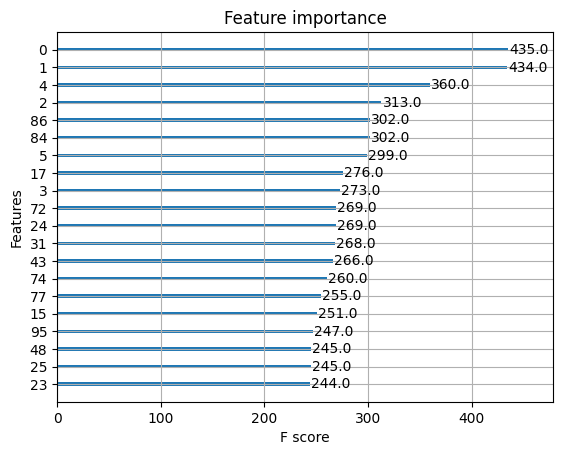

In [48]:
xgb.plot_importance(clf, max_num_features=20)

In [47]:
y_val_pred_proba = clf.predict_proba(X_val)[:, 1]  # take class=1 probability
auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC: {auc:.4f}")

Validation ROC AUC: 0.5865


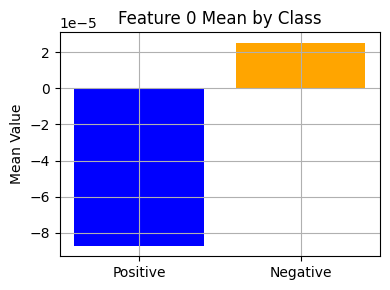

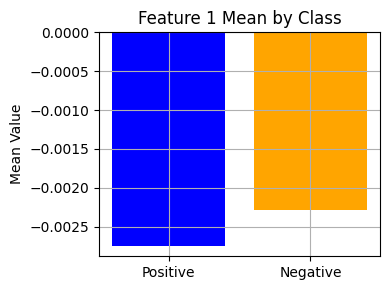

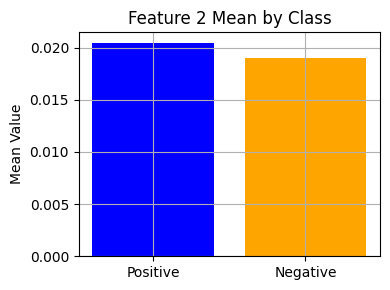

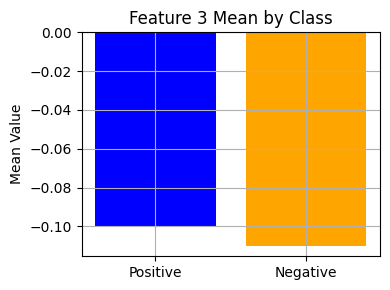

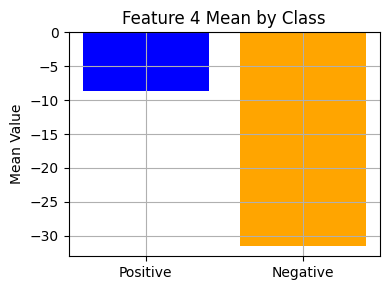

In [27]:
import matplotlib.pyplot as plt

# Ensure Xtr is a DataFrame or convert it
X_df = pd.DataFrame(Xtr)
y_arr = np.array(ytr)  # ensure it's aligned
# print(X_df.shape[1])
for i in range(X_df.shape[1]):
    plt.figure(figsize=(4, 3))

    pos_mean = X_df[y_arr == 1][i].mean()
    neg_mean = X_df[y_arr == 0][i].mean()

    plt.bar(['Positive', 'Negative'], [pos_mean, neg_mean], color=['blue', 'orange'])
    plt.title(f'Feature {i} Mean by Class')
    plt.ylabel('Mean Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    X_list = {id: group for id, group in X_train.groupby('id')}
    X = create_input(X_list)
    y = y_train.astype(int).values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = xgb.XGBClassifier(
        n_estimators=1000,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1.0,
        reg_alpha=0.1,
        reg_lambda=1.0,
        tree_method='hist',  # or 'gpu_hist' if you have GPU
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        device='cuda',
    )

    clf.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=10
    )


    model = clf

    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))

### `infer()`

In the inference function, the trained model is loaded and used to make inferences on a sample of data that matches the characteristics of the training test.

#### Setup

Once your model is loaded, you must do a `yield` to signal it to the runner. <br />
After that you can start reading data from `X_test`.

#### Iteration

The datasets must be read **one by one** and each value must be returned with a `yield <value>`. <br />
If you try to skip this, you will get an error. <br />
All values are then concatenated into a prediction file.

**Warning: The datasets can only be iterated once!**

#### Cleanup

Code can be executed after the `for` loop if you need to persist state or do some cleanup.

In [ ]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield  # mark as ready

    # X_test can only be iterated once.
    # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        # prediction = model.predict(dataset)
        features = extract_features(dataset)
        X = np.array(features).reshape(1, -1)
        pred = model.predict_proba(X)[0, 1]

        yield float(pred)  # send the prediction for the current dataset

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [ ]:
crunch.test(
    # Uncomment to disable the train
    # force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)

## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [ ]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

### Local scoring

You can call the function that the system uses to estimate your score locally.

In [ ]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"].astype(float)

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)